## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

Using TensorFlow backend.
C:\Users\percy\anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\percy\anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\percy\anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\percy\anaconda3\envs\te

In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
LEARNING_RATE = 1e-3
EPOCHS = 25 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 

In [7]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

"""Code Here
建立實驗的比較組合
"""
reduce_lr_factor = [0.5, 0.3, 0.1]
redice_lr_patient = [5, 3, 1]

In [8]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    reduce_lr = ReduceLROnPlateau(factor=reduce_factor,
                              min_lr=1e-12, 
                              monitor='val_loss', 
                              patience=reduce_patient, 
                              verbose=1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["accuracy"],
                             'valid-acc': model.history.history["val_accuracy"]}

Numbers of exp: 0, reduce_factor: 0.50, reduce_patient: 5
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
b

50000/50000 [==============================] - 1s 18us/step - loss: 1.3355 - accuracy: 0.5345 - val_loss: 1.5105 - val_accuracy: 0.4688
Epoch 10/25
50000/50000 [==============================] - 1s 18us/step - loss: 1.3049 - accuracy: 0.5468 - val_loss: 1.5064 - val_accuracy: 0.4668
Epoch 11/25
50000/50000 [==============================] - 1s 18us/step - loss: 1.2761 - accuracy: 0.5563 - val_loss: 1.4997 - val_accuracy: 0.4670
Epoch 12/25
50000/50000 [==============================] - 1s 18us/step - loss: 1.2507 - accuracy: 0.5661 - val_loss: 1.4761 - val_accuracy: 0.4820
Epoch 13/25
50000/50000 [==============================] - 1s 17us/step - loss: 1.2230 - accuracy: 0.5760 - val_loss: 1.4684 - val_accuracy: 0.4802
Epoch 14/25
50000/50000 [==============================] - 1s 18us/step - loss: 1.1977 - accuracy: 0.5857 - val_loss: 1.4628 - val_accuracy: 0.4853
Epoch 15/25
50000/50000 [==============================] - 1s 18us/step - loss: 1.1747 - accuracy: 0.5954 - val_loss: 1.4677

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 1s 25us/step - loss: 2.5192 - accuracy: 0.1987 - val_loss: 2.2235 - val_accuracy: 0.1457
Epoch 2/25
50000/50000 [==============================] - 1s 18us/step - loss: 2.0271 - accuracy: 0.3103 - val_loss: 2.1085 - val_accuracy: 0.2394
Epoch 3/25
50000/50000 [==============================] - 1s 18us/step - loss: 1.8667 - accuracy: 0.3534 - val_loss: 1.9859 - val_accuracy: 0.3105
Epoch 4/25
50000/50000 [==============================] - 1s 18us/step - loss: 1.7824 - accuracy: 0.3805 - val_loss: 1.8961 - val_accuracy: 0.3385
Epoch 5/25
50000/50000 [==============================] - 1s 18us/step - loss: 1.7259 - accuracy: 0.4021 - val_loss: 1.8097 - val_accuracy: 0.3705
Epoch 6/25
50000/50000 [==============================] - 1s 18us/step - loss: 1.6816 - accuracy: 0.4144 - val_loss: 1.7560 - val_accuracy: 0.3888
Epoch 7/25
50000/50000 [==============================] - 1s 18us/st

Epoch 21/25
50000/50000 [==============================] - 1s 18us/step - loss: 1.3803 - accuracy: 0.5218 - val_loss: 1.5580 - val_accuracy: 0.4459
Epoch 22/25
50000/50000 [==============================] - 1s 18us/step - loss: 1.3687 - accuracy: 0.5257 - val_loss: 1.5571 - val_accuracy: 0.4464
Epoch 23/25
50000/50000 [==============================] - 1s 18us/step - loss: 1.3566 - accuracy: 0.5305 - val_loss: 1.5494 - val_accuracy: 0.4516
Epoch 24/25
50000/50000 [==============================] - 1s 18us/step - loss: 1.3461 - accuracy: 0.5353 - val_loss: 1.5504 - val_accuracy: 0.4492
Epoch 25/25
50000/50000 [==============================] - 1s 18us/step - loss: 1.3348 - accuracy: 0.5383 - val_loss: 1.5350 - val_accuracy: 0.4578
Numbers of exp: 5, reduce_factor: 0.30, reduce_patient: 1
Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 3072)            

50000/50000 [==============================] - 1s 18us/step - loss: 1.9969 - accuracy: 0.3196 - val_loss: 1.9812 - val_accuracy: 0.2994
Epoch 6/25
50000/50000 [==============================] - 1s 18us/step - loss: 1.9427 - accuracy: 0.3359 - val_loss: 1.9319 - val_accuracy: 0.3183
Epoch 7/25
50000/50000 [==============================] - 1s 18us/step - loss: 1.8978 - accuracy: 0.3489 - val_loss: 1.8953 - val_accuracy: 0.3358
Epoch 8/25
50000/50000 [==============================] - 1s 18us/step - loss: 1.8609 - accuracy: 0.3599 - val_loss: 1.8685 - val_accuracy: 0.3494
Epoch 9/25
50000/50000 [==============================] - 1s 18us/step - loss: 1.8313 - accuracy: 0.3685 - val_loss: 1.8472 - val_accuracy: 0.3578
Epoch 10/25
50000/50000 [==============================] - 1s 18us/step - loss: 1.8031 - accuracy: 0.3758 - val_loss: 1.8320 - val_accuracy: 0.3642
Epoch 11/25
50000/50000 [==============================] - 1s 18us/step - loss: 1.7795 - accuracy: 0.3853 - val_loss: 1.8156 - v

50000/50000 [==============================] - 1s 18us/step - loss: 1.5929 - accuracy: 0.4404 - val_loss: 1.7064 - val_accuracy: 0.4048
Epoch 25/25
50000/50000 [==============================] - 1s 18us/step - loss: 1.5838 - accuracy: 0.4447 - val_loss: 1.7006 - val_accuracy: 0.4111
Numbers of exp: 8, reduce_factor: 0.10, reduce_patient: 1
Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_25 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_______________________________________________

Epoch 9/25
50000/50000 [==============================] - 1s 19us/step - loss: 1.0519 - accuracy: 0.6319 - val_loss: 1.7759 - val_accuracy: 0.4139
Epoch 10/25
50000/50000 [==============================] - 1s 19us/step - loss: 1.0126 - accuracy: 0.6461 - val_loss: 1.9139 - val_accuracy: 0.3905

Epoch 00010: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 11/25
50000/50000 [==============================] - 1s 19us/step - loss: 0.9062 - accuracy: 0.6882 - val_loss: 1.6316 - val_accuracy: 0.4380
Epoch 12/25
50000/50000 [==============================] - 1s 19us/step - loss: 0.8511 - accuracy: 0.7070 - val_loss: 1.5351 - val_accuracy: 0.4741
Epoch 13/25
50000/50000 [==============================] - 1s 19us/step - loss: 0.8108 - accuracy: 0.7239 - val_loss: 1.6833 - val_accuracy: 0.4587
Epoch 14/25
50000/50000 [==============================] - 1s 19us/step - loss: 0.7795 - accuracy: 0.7348 - val_loss: 1.6754 - val_accuracy: 0.4611
Epoch 15/25
50000/50000 [=======

50000/50000 [==============================] - 1s 19us/step - loss: 0.8454 - accuracy: 0.7271 - val_loss: 1.3737 - val_accuracy: 0.5225
Numbers of exp: 11, reduce_factor: 0.50, reduce_patient: 1
Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_34 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_35 (Batc (None, 256)               1024      
_____________________________________________________________

Epoch 10/25
50000/50000 [==============================] - 1s 19us/step - loss: 1.6550 - accuracy: 0.4220 - val_loss: 1.7137 - val_accuracy: 0.3953
Epoch 11/25
50000/50000 [==============================] - 1s 19us/step - loss: 1.6373 - accuracy: 0.4291 - val_loss: 1.7041 - val_accuracy: 0.3989
Epoch 12/25
50000/50000 [==============================] - 1s 19us/step - loss: 1.6234 - accuracy: 0.4344 - val_loss: 1.6969 - val_accuracy: 0.4031
Epoch 13/25
50000/50000 [==============================] - 1s 19us/step - loss: 1.6097 - accuracy: 0.4393 - val_loss: 1.6932 - val_accuracy: 0.4066
Epoch 14/25
50000/50000 [==============================] - 1s 19us/step - loss: 1.5964 - accuracy: 0.4433 - val_loss: 1.6868 - val_accuracy: 0.4081
Epoch 15/25
50000/50000 [==============================] - 1s 19us/step - loss: 1.5854 - accuracy: 0.4473 - val_loss: 1.6840 - val_accuracy: 0.4113
Epoch 16/25
50000/50000 [==============================] - 1s 19us/step - loss: 1.5740 - accuracy: 0.4511 - val_

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 2s 32us/step - loss: 2.4240 - accuracy: 0.2231 - val_loss: 2.2187 - val_accuracy: 0.1452
Epoch 2/25
50000/50000 [==============================] - 1s 19us/step - loss: 2.0123 - accuracy: 0.3164 - val_loss: 2.1279 - val_accuracy: 0.2187
Epoch 3/25
50000/50000 [==============================] - 1s 19us/step - loss: 1.8975 - accuracy: 0.3483 - val_loss: 2.0216 - val_accuracy: 0.2743
Epoch 4/25
50000/50000 [==============================] - 1s 19us/step - loss: 1.8325 - accuracy: 0.3691 - val_loss: 1.9255 - val_accuracy: 0.3223
Epoch 5/25
50000/50000 [==============================] - 1s 19us/step - loss: 1.7862 - accuracy: 0.3833 - val_loss: 1.8584 - val_accuracy: 0.3488
Epoch 6/25
50000/50000 [==============================] - 1s 19us/step - loss: 1.7496 - accuracy: 0.3948 - val_loss: 1.8052 - val_accuracy: 0.3646
Epoch 7/25
50000/50000 [==============================] - 1s 19us/st

50000/50000 [==============================] - 1s 20us/step - loss: 1.5402 - accuracy: 0.4663 - val_loss: 1.6859 - val_accuracy: 0.4220
Epoch 21/25
50000/50000 [==============================] - 1s 20us/step - loss: 1.5313 - accuracy: 0.4707 - val_loss: 1.6815 - val_accuracy: 0.4237
Epoch 22/25
50000/50000 [==============================] - 1s 20us/step - loss: 1.5222 - accuracy: 0.4724 - val_loss: 1.6762 - val_accuracy: 0.4244
Epoch 23/25
50000/50000 [==============================] - 1s 20us/step - loss: 1.5147 - accuracy: 0.4756 - val_loss: 1.6723 - val_accuracy: 0.4256
Epoch 24/25
50000/50000 [==============================] - 1s 21us/step - loss: 1.5061 - accuracy: 0.4782 - val_loss: 1.6682 - val_accuracy: 0.4281
Epoch 25/25
50000/50000 [==============================] - 1s 20us/step - loss: 1.4974 - accuracy: 0.4799 - val_loss: 1.6631 - val_accuracy: 0.4301
Numbers of exp: 16, reduce_factor: 0.10, reduce_patient: 3
Model: "model_17"
_______________________________________________

Epoch 5/25
50000/50000 [==============================] - 1s 20us/step - loss: 1.7750 - accuracy: 0.3871 - val_loss: 1.8457 - val_accuracy: 0.3599
Epoch 6/25
50000/50000 [==============================] - 1s 20us/step - loss: 1.7399 - accuracy: 0.3983 - val_loss: 1.7945 - val_accuracy: 0.3761
Epoch 7/25
50000/50000 [==============================] - 1s 20us/step - loss: 1.7126 - accuracy: 0.4085 - val_loss: 1.7616 - val_accuracy: 0.3833
Epoch 8/25
50000/50000 [==============================] - 1s 20us/step - loss: 1.6882 - accuracy: 0.4163 - val_loss: 1.7360 - val_accuracy: 0.3920
Epoch 9/25
50000/50000 [==============================] - 1s 20us/step - loss: 1.6669 - accuracy: 0.4219 - val_loss: 1.7188 - val_accuracy: 0.3976
Epoch 10/25
50000/50000 [==============================] - 1s 20us/step - loss: 1.6494 - accuracy: 0.4285 - val_loss: 1.7074 - val_accuracy: 0.4070
Epoch 11/25
50000/50000 [==============================] - 1s 21us/step - loss: 1.6331 - accuracy: 0.4332 - val_loss:

50000/50000 [==============================] - 1s 20us/step - loss: 0.5628 - accuracy: 0.8136 - val_loss: 1.6615 - val_accuracy: 0.4803
Epoch 25/25
50000/50000 [==============================] - 1s 20us/step - loss: 0.5435 - accuracy: 0.8211 - val_loss: 1.7212 - val_accuracy: 0.4816
Numbers of exp: 19, reduce_factor: 0.50, reduce_patient: 3
Model: "model_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_58 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_____________________________________________

Epoch 7/25
50000/50000 [==============================] - 1s 21us/step - loss: 1.4694 - accuracy: 0.4912 - val_loss: 1.6146 - val_accuracy: 0.4281
Epoch 8/25
50000/50000 [==============================] - 1s 20us/step - loss: 1.4329 - accuracy: 0.5029 - val_loss: 1.6057 - val_accuracy: 0.4320
Epoch 9/25
50000/50000 [==============================] - 1s 20us/step - loss: 1.3995 - accuracy: 0.5158 - val_loss: 1.5729 - val_accuracy: 0.4416
Epoch 10/25
50000/50000 [==============================] - 1s 20us/step - loss: 1.3694 - accuracy: 0.5279 - val_loss: 1.5646 - val_accuracy: 0.4463
Epoch 11/25
50000/50000 [==============================] - 1s 20us/step - loss: 1.3435 - accuracy: 0.5392 - val_loss: 1.5354 - val_accuracy: 0.4637
Epoch 12/25
50000/50000 [==============================] - 1s 20us/step - loss: 1.3159 - accuracy: 0.5485 - val_loss: 1.5393 - val_accuracy: 0.4611

Epoch 00012: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
Epoch 13/25
50000/50000 [========

Epoch 25/25
50000/50000 [==============================] - 1s 20us/step - loss: 1.8103 - accuracy: 0.3718 - val_loss: 1.8638 - val_accuracy: 0.3548
Numbers of exp: 22, reduce_factor: 0.30, reduce_patient: 3
Model: "model_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_23 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_67 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_68 (Batc (None, 256)               1024      
_________________________________________________

Epoch 10/25
50000/50000 [==============================] - 1s 20us/step - loss: 2.1208 - accuracy: 0.2839 - val_loss: 2.0928 - val_accuracy: 0.2776
Epoch 11/25
50000/50000 [==============================] - 1s 20us/step - loss: 2.0869 - accuracy: 0.2942 - val_loss: 2.0734 - val_accuracy: 0.2862
Epoch 12/25
50000/50000 [==============================] - 1s 20us/step - loss: 2.0555 - accuracy: 0.3027 - val_loss: 2.0550 - val_accuracy: 0.2939
Epoch 13/25
50000/50000 [==============================] - 1s 20us/step - loss: 2.0286 - accuracy: 0.3103 - val_loss: 2.0404 - val_accuracy: 0.3013
Epoch 14/25
50000/50000 [==============================] - 1s 20us/step - loss: 2.0027 - accuracy: 0.3178 - val_loss: 2.0241 - val_accuracy: 0.3054
Epoch 15/25
50000/50000 [==============================] - 1s 21us/step - loss: 1.9794 - accuracy: 0.3254 - val_loss: 2.0084 - val_accuracy: 0.3105
Epoch 16/25
50000/50000 [==============================] - 1s 20us/step - loss: 1.9586 - accuracy: 0.3314 - val_

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 2s 37us/step - loss: 2.8939 - accuracy: 0.1221 - val_loss: 2.3109 - val_accuracy: 0.1316
Epoch 2/25
50000/50000 [==============================] - 1s 20us/step - loss: 2.6774 - accuracy: 0.1592 - val_loss: 2.2751 - val_accuracy: 0.1464
Epoch 3/25
50000/50000 [==============================] - 1s 21us/step - loss: 2.5280 - accuracy: 0.1917 - val_loss: 2.2381 - val_accuracy: 0.1699
Epoch 4/25
50000/50000 [==============================] - 1s 20us/step - loss: 2.4194 - accuracy: 0.2172 - val_loss: 2.1939 - val_accuracy: 0.2025
Epoch 5/25
50000/50000 [==============================] - 1s 20us/step - loss: 2.3375 - accuracy: 0.2357 - val_loss: 2.1530 - val_accuracy: 0.2263
Epoch 6/25
50000/50000 [==============================] - 1s 20us/step - loss: 2.2703 - accuracy: 0.2508 - val_loss: 2.1189 - val_accuracy: 0.2471
Epoch 7/25
50000/50000 [==============================] - 1s 20us/st

50000/50000 [==============================] - 1s 21us/step - loss: 1.9089 - accuracy: 0.3444 - val_loss: 1.9549 - val_accuracy: 0.3237
Epoch 21/25
50000/50000 [==============================] - 1s 21us/step - loss: 1.8938 - accuracy: 0.3491 - val_loss: 1.9408 - val_accuracy: 0.3281
Epoch 22/25
50000/50000 [==============================] - 1s 21us/step - loss: 1.8802 - accuracy: 0.3524 - val_loss: 1.9284 - val_accuracy: 0.3323
Epoch 23/25
50000/50000 [==============================] - 1s 20us/step - loss: 1.8664 - accuracy: 0.3574 - val_loss: 1.9177 - val_accuracy: 0.3363
Epoch 24/25
50000/50000 [==============================] - 1s 21us/step - loss: 1.8530 - accuracy: 0.3598 - val_loss: 1.9063 - val_accuracy: 0.3408
Epoch 25/25
50000/50000 [==============================] - 1s 20us/step - loss: 1.8399 - accuracy: 0.3646 - val_loss: 1.8958 - val_accuracy: 0.3433


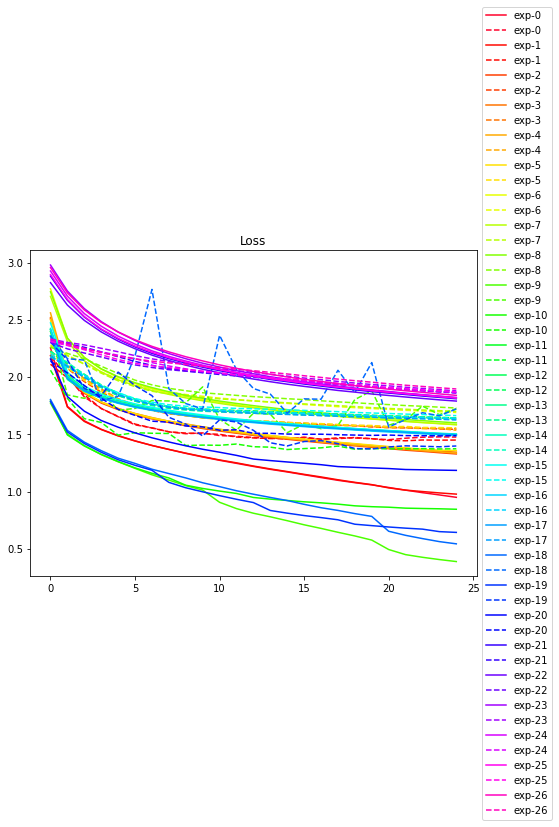

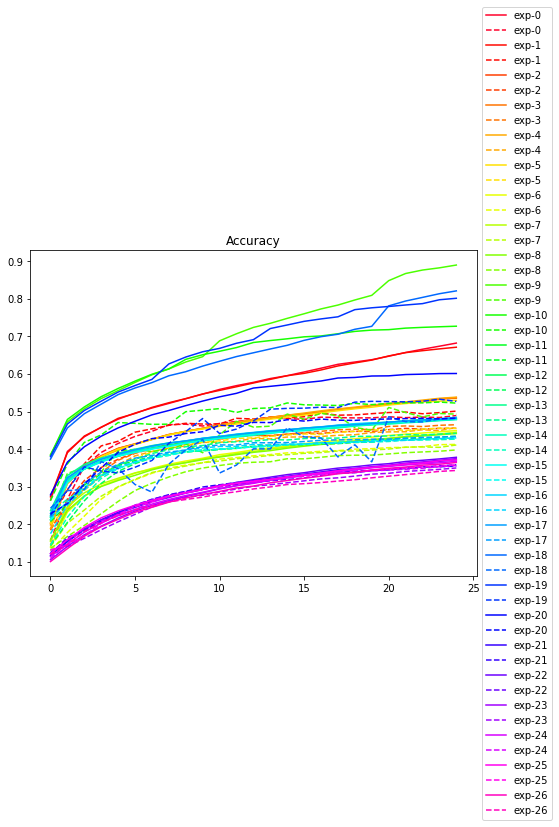

In [9]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()